# Test imports, configs, etc

In [2]:
# custom classes
from SatellitesDataset import get_test_dataset,get_train_dataset,SatellitesDataset
from SatellitesAugs import SatellitesTrainAugmentation,SatellitesTestAugmentation
from Loss import BCEDiceLoss
from LinkNet import LinkNet34
from UNet import UNet11
from presets import preset_dict

preset = 'rgb_ps'
bit8_imgs,bit8_masks,cty_no = get_train_dataset(preset,preset_dict)
or_imgs,cty_no_mask = get_test_dataset(preset,preset_dict)
len(bit8_imgs),len(bit8_masks),len(cty_no),len(or_imgs),len(cty_no_mask)

from sklearn.model_selection import train_test_split

train_imgs, val_imgs, train_masks, val_masks = train_test_split(bit8_imgs,
                                                                bit8_masks,
                                                                test_size=0.2,
                                                                stratify = cty_no,
                                                                random_state=42)

len(train_imgs),len(train_masks)

train_augs = SatellitesTrainAugmentation(shape=1280,
                                         aug_scheme = None
                                        )

val_augs = SatellitesTestAugmentation(shape=1280)

dataset = SatellitesDataset(preset = preset_dict[preset],
            image_paths = train_imgs,
             mask_paths = train_masks,                 
             transforms = train_augs,
            )

Augmentations are NOT enabled for train


In [6]:
import pandas as pd
pd.DataFrame(cty_no)[0].value_counts()

3    1028
0     981
1     283
2     257
Name: 0, dtype: int64

In [4]:
import random

img,mask  = dataset.__getitem__(random.randint(0,100))

In [7]:
mask

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.85227275, 0.85227275,
        0.85227275],
       [0.        , 0.        , 0.        , ..., 0.85227275, 0.85227275,
        0.85227275],
       [0.        , 0.        , 0.        , ..., 0.01704546, 0.01704546,
        0.01704546]], dtype=float32)

start
image processing complete 0.12017488479614258


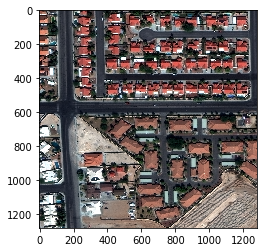

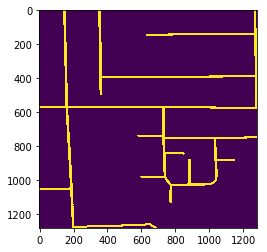

plotting complete 0.42572522163391113


In [25]:
import matplotlib.pyplot as plt
import time
import random
import numpy as np

start = time.time()
print("start")

img,mask  = dataset.__getitem__(random.randint(0,100))

end = time.time()
print('image processing complete', end - start)

img = img.cpu().numpy().astype(np.float32).transpose((1, 2, 0))
img += -img.min()
img *= (1/img.max())

plt.imshow(img)
plt.show()

mask = mask.cpu().numpy().astype(np.float32).transpose((1, 2, 0))[:,:,0]
mask += -mask.min()
mask *= (1/mask.max())

plt.imshow(mask)
plt.show()

end = time.time()
print('plotting complete', end - start)

In [4]:
mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

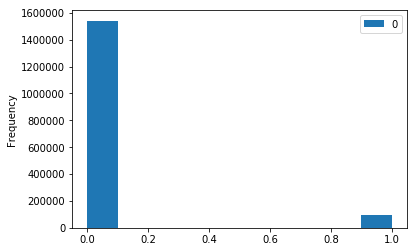

In [5]:
import pandas as pd

df = pd.DataFrame(mask.reshape(-1,1))
df.plot(kind='hist')
plt.show()

In [6]:
img,mask  = dataset.__getitem__(random.randint(0,100))

In [11]:
mask.min()

0.0

In [26]:
1280*1280

1638400

In [23]:
(np.asarray(mask) > 0.5).astype(np.uint8).sum()

122794

In [12]:
test.astype(np.uint8)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [25]:
    print('Train images: {}\t'
          'Train  masks: {}\t'
          'Val   images: {}\t'
          'Val    masks: {}\t'.format(len([1]),len([1]),
                                      len([1]),len([1])))

Train images: 1	Train  masks: 1	Val   images: 1	Val    masks: 1	


In [27]:
import shutil

shutil.rmtree('tb_logs/test/')

PermissionError: [Errno 13] Permission denied: 'events.out.tfevents.1515653499.4c3715934f1a'

# Try the 8-channel model

In [12]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
import torch.nn.functional as F

nonlinearity = nn.ReLU

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, n_filters):
        super().__init__()

        # B, C, H, W -> B, C/4, H, W
        self.conv1 = nn.Conv2d(in_channels, in_channels // 4, 1)
        self.norm1 = nn.BatchNorm2d(in_channels // 4)
        self.relu1 = nonlinearity(inplace=True)

        # B, C/4, H, W -> B, C/4, H, W
        self.deconv2 = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, 3,
                                          stride=2, padding=1, output_padding=1)
        self.norm2 = nn.BatchNorm2d(in_channels // 4)
        self.relu2 = nonlinearity(inplace=True)

        # B, C/4, H, W -> B, C, H, W
        self.conv3 = nn.Conv2d(in_channels // 4, n_filters, 1)
        self.norm3 = nn.BatchNorm2d(n_filters)
        self.relu3 = nonlinearity(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.deconv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu3(x)
        return x

class LinkNet34(nn.Module):
    def __init__(self, num_classes, num_channels=3):
        super().__init__()
        
        filters = [64, 128, 256, 512]
        resnet = models.resnet34(pretrained=True)

        # self.firstconv = resnet.conv1
        # assert num_channels == 3, "num channels not used now. to use changle first conv layer to support num channels other then 3"
        # try to use 8-channels as first input
        if num_channels==3:
            self.firstconv = resnet.conv1
        else:
            self.firstconv = nn.Conv2d(num_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
        
        self.firstbn = resnet.bn1
        self.firstrelu = resnet.relu
        self.firstmaxpool = resnet.maxpool
        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4

        # Decoder
        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        # Final Classifier
        self.finaldeconv1 = nn.ConvTranspose2d(filters[0], 32, 3, stride=2)
        self.finalrelu1 = nonlinearity(inplace=True)
        self.finalconv2 = nn.Conv2d(32, 32, 3)
        self.finalrelu2 = nonlinearity(inplace=True)
        self.finalconv3 = nn.Conv2d(32, num_classes, 2, padding=1)

    # noinspection PyCallingNonCallable
    def forward(self, x):
        # Encoder
        x = self.firstconv(x)
        x = self.firstbn(x)
        x = self.firstrelu(x)
        x = self.firstmaxpool(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Decoder with Skip Connections
        d4 = self.decoder4(e4) + e3
        # d4 = e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)

        # Final Classification
        f1 = self.finaldeconv1(d1)
        f2 = self.finalrelu1(f1)
        f3 = self.finalconv2(f2)
        f4 = self.finalrelu2(f3)
        f5 = self.finalconv3(f4)

        # return f5 
        return F.sigmoid(f5)

In [14]:
model = LinkNet34(num_classes=1,
                 num_channels=8)

In [15]:
model

LinkNet34 (
  (firstconv): Conv2d(8, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (firstbn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (firstrelu): ReLU (inplace)
  (firstmaxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (encoder1): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): 

In [16]:
inputs = torch.autograd.Variable(torch.randn(1,8,320,320))
out = model(inputs)
print (out.size())

torch.Size([1, 1, 320, 320])


In [29]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
from torch.nn import functional as F

def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)

def concat(xs):
    return torch.cat(xs, 1)

class Conv3BN(nn.Module):
    def __init__(self, in_: int, out: int, bn=False):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.bn = nn.BatchNorm2d(out) if bn else None
        self.activation = nn.SELU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        x = self.activation(x)
        return x

class UNetModule(nn.Module):
    def __init__(self, in_: int, out: int):
        super().__init__()
        self.l1 = Conv3BN(in_, out)
        self.l2 = Conv3BN(out, out)

    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        return x

class ConvRelu(nn.Module):
    def __init__(self, in_: int, out: int):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()

        self.block = nn.Sequential(
            ConvRelu(in_channels, middle_channels),
            nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)      
    
class UNet11(nn.Module):
    def __init__(self,
                 
                 num_classes=1,
                 num_filters=32,
                 num_channels=3):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        encoder = models.vgg11(pretrained=True).features
        self.relu = encoder[1]
        
        # try to use 8-channels as first input
        if num_channels==3:
            self.conv1 = self.encoder[0]
        else:
            self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))    
        
        self.conv2 = encoder[3]
        self.conv3s = encoder[6]
        self.conv3 = encoder[8]
        self.conv4s = encoder[11]
        self.conv4 = encoder[13]
        self.conv5s = encoder[16]
        self.conv5 = encoder[18]

        self.center = DecoderBlock(num_filters * 8 * 2, num_filters * 8 * 2, num_filters * 8)
        self.dec5 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 8)
        self.dec4 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 4)
        self.dec3 = DecoderBlock(num_filters * (8 + 4), num_filters * 4 * 2, num_filters * 2)
        self.dec2 = DecoderBlock(num_filters * (4 + 2), num_filters * 2 * 2, num_filters)
        self.dec1 = ConvRelu(num_filters * (2 + 1), num_filters)

        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        conv1 = self.relu(self.conv1(x))
        conv2 = self.relu(self.conv2(self.pool(conv1)))
        conv3s = self.relu(self.conv3s(self.pool(conv2)))
        conv3 = self.relu(self.conv3(conv3s))
        conv4s = self.relu(self.conv4s(self.pool(conv3)))
        conv4 = self.relu(self.conv4(conv4s))
        conv5s = self.relu(self.conv5s(self.pool(conv4)))
        conv5 = self.relu(self.conv5(conv5s))

        center = self.center(self.pool(conv5))

        dec5 = self.dec5(torch.cat([center, conv5], 1))
        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(torch.cat([dec2, conv1], 1))
        return F.sigmoid(self.final(dec1))


In [31]:
model = UNet11(num_classes=1,
               num_filters=32,
               num_channels=8)

model

UNet11 (
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (relu): ReLU (inplace)
  (conv1): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3s): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4s): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5s): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (center): DecoderBlock (
    (block): Sequential (
      (0): ConvRelu (
        (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU (inplace)
      )
      (1): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(

In [32]:
inputs = torch.autograd.Variable(torch.randn(1,8,320,320))
out = model(inputs)
print (out.size())

torch.Size([1, 1, 320, 320])


# Generate masks by myself 

In [6]:
!ls ../data/AOI_2_Vegas_Roads_Train/summaryData

AOI_2_Vegas_Roads_Train.csv


In [7]:
from presets import preset_dict

data_prefix = '../data'

folders = ['AOI_2_Vegas_Roads_Train',
           'AOI_5_Khartoum_Roads_Train',
           'AOI_3_Paris_Roads_Train',
           'AOI_4_Shanghai_Roads_Train']



In [13]:
import os

path = os.path.join(data_prefix,folders[0],'summaryData',folders[0]+'.csv')

In [15]:
import pandas as pd

ls_df = pd.read_csv(path)
ls_df.head()

,ImageId,WKT_Pix
0,AOI_2_Vegas_img885,"LINESTRING (1300.00 662.42, 1231.00 657.56, 11..."
1,AOI_2_Vegas_img885,"LINESTRING (314.59 1300.00, 315.13 1229.58, 32..."
2,AOI_2_Vegas_img885,"LINESTRING (327.09 327.01, 323.18 0.00)"
3,AOI_2_Vegas_img885,"LINESTRING (911.19 1138.18, 611.40 1139.32, 58..."
4,AOI_2_Vegas_img885,"LINESTRING (437.92 1300.00, 474.45 1282.97)"


In [16]:
ls_df[ls_df.ImageId=='AOI_2_Vegas_img885']

,ImageId,WKT_Pix
0,AOI_2_Vegas_img885,"LINESTRING (1300.00 662.42, 1231.00 657.56, 11..."
1,AOI_2_Vegas_img885,"LINESTRING (314.59 1300.00, 315.13 1229.58, 32..."
2,AOI_2_Vegas_img885,"LINESTRING (327.09 327.01, 323.18 0.00)"
3,AOI_2_Vegas_img885,"LINESTRING (911.19 1138.18, 611.40 1139.32, 58..."
4,AOI_2_Vegas_img885,"LINESTRING (437.92 1300.00, 474.45 1282.97)"
5,AOI_2_Vegas_img885,"LINESTRING (1145.53 319.63, 1145.83 659.57, 11..."
6,AOI_2_Vegas_img885,"LINESTRING (1145.53 319.63, 1142.97 0.00)"


In [25]:
sample = meta_df[meta_df.img_subfolders.str.contains("AOI_2_Vegas_img885") ]

In [26]:
sample

,Unnamed: 0,width,height,channels,im_size,ctime,mtime,img_files,img_folders,img_subfolders
1428,1428,1300,1300,1,3383838,1.515131e+09,1.510776e+09,AOI_2_Vegas_Roads_Train,PAN,PAN_AOI_2_Vegas_img885.tif
2414,2414,1300,1300,3,10150778,1.515131e+09,1.510776e+09,AOI_2_Vegas_Roads_Train,RGB-PanSharpen,RGB-PanSharpen_AOI_2_Vegas_img885.tif
3645,3645,1300,1300,8,27050820,1.515132e+09,1.510776e+09,AOI_2_Vegas_Roads_Train,MUL-PanSharpen,MUL-PanSharpen_AOI_2_Vegas_img885.tif
5246,5246,325,325,8,1693020,1.515131e+09,1.510776e+09,AOI_2_Vegas_Roads_Train,MUL,MUL_AOI_2_Vegas_img885.tif


In [32]:
img_path1 = os.path.join(data_prefix,sample[sample.img_folders=='PAN'].img_files.values[0],sample[sample.img_folders=='PAN'].img_folders.values[0],sample[sample.img_folders=='PAN'].img_subfolders.values[0])
img_path2 = os.path.join(data_prefix,sample[sample.img_folders=='RGB-PanSharpen'].img_files.values[0],sample[sample.img_folders=='RGB-PanSharpen'].img_folders.values[0],sample[sample.img_folders=='RGB-PanSharpen'].img_subfolders.values[0])
img_path3 = os.path.join(data_prefix,sample[sample.img_folders=='MUL-PanSharpen'].img_files.values[0],sample[sample.img_folders=='MUL-PanSharpen'].img_folders.values[0],sample[sample.img_folders=='MUL-PanSharpen'].img_subfolders.values[0])
img_path4 = os.path.join(data_prefix,sample[sample.img_folders=='MUL'].img_files.values[0],sample[sample.img_folders=='MUL'].img_folders.values[0],sample[sample.img_folders=='MUL'].img_subfolders.values[0])


In [51]:
import numpy as np

img1 = read_image(preset_dict['pan'],img_path1)
img2 = read_image(preset_dict['rgb_ps'],img_path2)
img3 = read_image(preset_dict['mul_ps_vegetation'],img_path3)
img4 = read_image(preset_dict['mul_vegetation'],img_path4)

In [52]:
img1.max()

1.0

In [ ]:
plt.imshow(img1)
img1 += -img1.min()
img1 *= (1/img1.max())
plt.show()


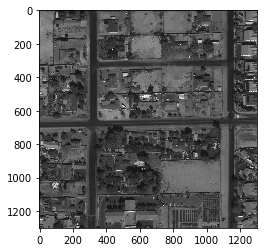

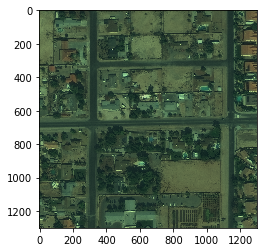

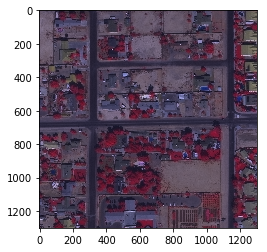

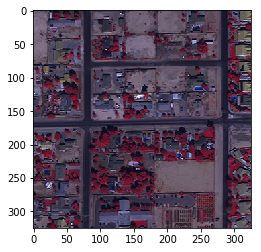

In [50]:
import matplotlib.pyplot as plt

plt.imshow(img1)
img1 += -imga1.min()
img1 *= (1/img1.max())
plt.show()

plt.imshow(img2)
img2 += -img2.min()
img2 *= (1/img2.max())
plt.show()

plt.imshow(img3)
img3 += -img3.min()
img3 *= (1/img3.max())
plt.show()

plt.imshow(img4)
img4 += -img4.min()
img4 *= (1/img4.max())
plt.show()

In [31]:
!ls $img1

../data/AOI_2_Vegas_Roads_Train/PAN/PAN_AOI_2_Vegas_img885.tif


In [49]:
from skimage.io import imread
from skimage import img_as_ubyte
from skimage import exposure

def read_image(preset,path):
    img = imread(path)
    target_channels = np.zeros(shape=(preset['width'],preset['width'],len(preset['channels'])))

    # expand grayscale images to 3 dimensions
    if len(img.shape)<3:
        img = np.expand_dims(img, 2)                

    for i,channel in enumerate(preset['channels']):
        target_channels[:,:,i] = img[:,:,channel-1]

    target_channels = exposure.rescale_intensity(target_channels, in_range='uint8')           

    return target_channels

In [ ]:
img = read_image(preset,path)

In [18]:
meta_df = pd.read_csv('../metadata.csv')
meta_df.head()

,Unnamed: 0,width,height,channels,im_size,ctime,mtime,img_files,img_folders,img_subfolders
0,0,1300,1300,1,3383838,1.515131e+09,1.511274e+09,AOI_2_Vegas_Roads_Test_Public,PAN,PAN_AOI_2_Vegas_img1510.tif
1,1,1300,1300,1,3383838,1.515131e+09,1.511274e+09,AOI_2_Vegas_Roads_Test_Public,PAN,PAN_AOI_2_Vegas_img338.tif
2,2,1300,1300,1,3383838,1.515131e+09,1.511274e+09,AOI_2_Vegas_Roads_Test_Public,PAN,PAN_AOI_2_Vegas_img1468.tif
3,3,1300,1300,1,3383838,1.515131e+09,1.511274e+09,AOI_2_Vegas_Roads_Test_Public,PAN,PAN_AOI_2_Vegas_img857.tif
4,4,1300,1300,1,3383838,1.515131e+09,1.511274e+09,AOI_2_Vegas_Roads_Test_Public,PAN,PAN_AOI_2_Vegas_img86.tif


In [ ]:
def 

In [ ]:
import numpy as np
import pandas as pd
import re
import rasterio
from PyQt5.QtGui import QPainter, QColor, QImage, QPolygonF
from PyQt5 import QtCore, QtGui
from PyQt5.QtCore import Qt


data_dir = '../input/SpaceNet_Roads_Sample/AOI_2_Vegas_Roads_Sample/'
roads_data = pd.read_csv(data_dir+'summaryData/AOI_2_Vegas_Roads_Sample.csv')
roads_data.head()

img_id = 'AOI_2_Vegas_img1454'
lines = list(roads_data[roads_data.ImageId == img_id].WKT_Pix)

mask = QImage(1300, 1300, QImage.Format_RGB32)
mask.fill(Qt.black)

painter = QPainter(mask)
pen = QtGui.QPen(Qt.white)
pen.setWidth(16)
pen.setCapStyle(Qt.RoundCap)
painter.setPen(pen)

for i, line in enumerate(lines):
    items = line[len('LINESTRING ('):-1].split(',')
    points = []

    polygon = QPolygonF()
    for item in items:
        x, y = item.split()
        point = [float(x), float(y)]
        points.append(point)
        polygon.append(QtCore.QPointF(point[0], point[1]))
    print(points)
    painter.drawPolyline(polygon)


painter.end()
mask.save(f'mask.png')